In [107]:
import numpy as np
import os
import torch
from collections import Counter
from sklearn.feature_extraction import stop_words
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

In [108]:
# hyper parameters
learning_rate = 0.001
vocab_size = 20000 # number of n-grams to use
emb_dim = 50 
num_epochs = 5 
batch_size = 32
ngram_n = 2

In [109]:
data_dir = "../aclImdb/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
TRAIN_SIZE = 20000
VALIDATION_SIZE = 5000
TEST_SIZE = 25000
PADDING_IDX = 0

## Load Data and Raw Text Preprocessing

In [110]:
def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", "")
    return text
        
    
def read_file_as_datum(file_name, label):
    """
    Function that reads a file 
    """
    with open(file_name, "r") as f:
        content = f.read()
        content = preprocess_text(content)
    return IMDBDatum(raw_text=content, label=label, file_name=file_name)


def construct_dataset(dataset_dir, dataset_size, offset=0):
    """
    Function that loads a dataset
    @param offset: skip first offset items in this dir
    """
    pos_dir = os.path.join(dataset_dir, "pos")
    neg_dir = os.path.join(dataset_dir, "neg")
    single_label_size = int(dataset_size / 2)
    output = []
    all_pos = os.listdir(pos_dir)
    all_neg = os.listdir(neg_dir)
    for i in range(offset, offset+single_label_size):
        output.append(read_file_as_datum(os.path.join(pos_dir, all_pos[i]), 1))
        output.append(read_file_as_datum(os.path.join(neg_dir, all_neg[i]), 0))
    return output


In [111]:
class IMDBDatum():
    """
    Class that represents a train/validation/test datum
    - self.raw_text
    - self.label: 0 neg, 1 pos
    - self.file_name: dir for this datum
    - self.tokens: list of tokens
    - self.token_idx: index of each token in the text
    """
    def __init__(self, raw_text, label, file_name):
        self.raw_text = raw_text
        self.label = label
        self.file_name = file_name
        
    def set_ngram(self, ngram_ctr):
        self.ngram = ngram_ctr
    
    def set_token_idx(self, token_idx):
        self.token_idx = token_idx
        
    def set_tokens(self, tokens):
        self.tokens = tokens

In [112]:
# Load Dataset - should take less than 1 min
train_set = construct_dataset(train_dir, TRAIN_SIZE)
validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
test_set = construct_dataset(test_dir, TEST_SIZE)

In [115]:
print(train_set[0].raw_text)

for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. imagine a movie where joe piscopo is actually funny! maureen stapleton is a scene stealer. the moroni character is an absolute scream. watch for alan "the skipper" hale jr. as a police sgt.


## Tokenize Data to Ngrams

In [116]:
def extract_ngram_from_text(text, n, remove_stopwords=True):
    """
    Function that retrieves all n-grams from the input string
    @param text: raw string
    @param n: integer that tells the model to retrieve all k-gram where k<=n
    @return ngram_counter: a counter that maps n-gram to its frequency
    @return tokens: a list of parsed ngrams
    """
    # tokenize words - for simplicity just split by space
    tokens = text.split(" ")
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words.ENGLISH_STOP_WORDS]
    # extract n grams
    # TODO: replace with your code
    ngram_counter = Counter()
    ngram_counter.update(tokens)
    for j in np.arange(n):
        if j > 0:
            for i in np.arange(len(tokens)-j):
                ngram_counter[" ".join(tokens[i:i+j+1])]+=1
    all_ngrams = ngram_counter.keys()
    return ngram_counter, all_ngrams


def construct_ngram_indexer(ngram_counter_list, topk):
    """
    Function that selects the most common topk ngrams
    @param ngram_counter_list: list of counters
    @param topk, int: # of 
    @return ngram2idx: a dictionary that maps ngram to an unique index
    """
    # TODO: fill in your code here
    # find the top k ngram
    # maps the ngram to an unique index
    ngram_counter_sum = Counter()
    for ngram_counter in ngram_counter_list:
        ngram_counter_sum.update(ngram_counter)
    most_common = ngram_counter_sum.most_common(topk)
    ngram_indexer = {}
    for i in np.arange(topk):
        ngram_indexer[most_common[i][0]] = i+1
    return ngram_indexer


def token_to_index(tokens, ngram_indexer):
    """
    Function that transform a list of tokens to a list of token index.
    @param tokens: list of ngram
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # TODO: replace with your code
    # Please DO NOT assign any ngram to index 0 which is reserved for PAD token
    index_list = []
    for token in tokens:
        if token in ngram_indexer:
            index_list.append(ngram_indexer[token])
    return index_list


def process_text_dataset(dataset, n, topk=None, ngram_indexer=None):
    """
    Top level function that encodes each datum into a list of ngram indices
    @param dataset: list of IMDBDatum
    @param n: n in "n-gram"
    @param topk: #
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # extract n-gram
    for i in range(len(dataset)):
        text_datum = dataset[i].raw_text
        ngrams, tokens = extract_ngram_from_text(text_datum, n)
        dataset[i].set_ngram(ngrams)
        dataset[i].set_tokens(tokens)
    # select top k ngram
    if ngram_indexer is None:
        ngram_indexer = construct_ngram_indexer([datum.ngram for datum in dataset], topk)
    # vectorize each datum
    for i in range(len(dataset)):
        dataset[i].set_token_idx(token_to_index(dataset[i].tokens, ngram_indexer))  
    return dataset, ngram_indexer


In [117]:
# convert text data into list of index - should take less than 2 mins
# Note that we are using the train_ngram_indexer to index validation and test dataset. Why? 
train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

In [92]:
class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list):
        """
        @param data_list: list of IMDBDatum
        """
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx, label = self.data_list[key].token_idx, self.data_list[key].label
        return (token_idx, len(token_idx)), label
    

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[1])
        length_list.append(datum[0][1])
    max_length = np.max(length_list)
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0][0]), 
                                pad_width=((0,max_length-datum[0][1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
    

# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    
    
# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [93]:
print("This is an training sample: {0}".format(imdb_train[0][0]))
print("This is a label: {0}".format(imdb_train[0][1]))

This is an training sample: ([1, 69, 1132, 122, 55, 815, 6614, 3947, 5075, 635, 748, 49, 7776, 9217, 42, 30, 1237, 17863, 19, 1405, 82, 14132, 3100, 381, 8764, 4701, 14774], 27)
This is a label: 1


In [ ]:
class FastText(nn.Module):
    """
    FastText model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()
        # TODO: replace with your code
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        
        self.embedding = nn.Embedding(vocab_size + 1, emb_dim, padding_idx = 0)
        self.linear = nn.Linear(emb_dim, 1)
        
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        # TODO: replace with your code
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        # The output of this function should be a Tensor of dimension (batch_size). Each of the dimension contains
        # a float in the range [0,1] that denotes the probability that the sample is positive (1).
        data = data.type(torch.LongTensor)
        data_embedded = self.embedding(data)
        out = self.linear(data_embedded)
        out = torch.mean(out, 1).view(-1)
        out = out * data.size()[1] / length.type(torch.FloatTensor)
        return nn.functional.sigmoid(out)
    
model = FastText(vocab_size, emb_dim)

## Albation Study

### Tokenization Schemes

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.6831235289573669, Train Acc: 61, Validation Acc:60
Epoch: [1/5], Step: [256/625], Loss: 0.6519333720207214, Train Acc: 74, Validation Acc:72
Epoch: [1/5], Step: [384/625], Loss: 0.6317045092582703, Train Acc: 79, Validation Acc:77
Epoch: [1/5], Step: [512/625], Loss: 0.5947754979133606, Train Acc: 82, Validation Acc:79
Epoch: [2/5], Step: [128/625], Loss: 0.4294409453868866, Train Acc: 85, Validation Acc:82
Epoch: [2/5], Step: [256/625], Loss: 0.42104843258857727, Train Acc: 86, Validation Acc:83
Epoch: [2/5], Step: [384/625], Loss: 0.4503103494644165, Train Acc: 87, Validation Acc:84
Epoch: [2/5], Step: [512/625], Loss: 0.43030065298080444, Train Acc: 88, Validation Acc:85
Epoch: [3/5], Step: [128/625], Loss: 0.3713608384132385, Train Acc: 89, Validation Acc:85
Epoch: [3/5], Step: [256/625], Loss: 0.3532329201698303, Train Acc: 90, Validation Acc:86
Epoch: [3/5], Step: [384/625], Loss: 0.22804760932922363, Train Acc: 90, Validation Acc:86
Epoch: 

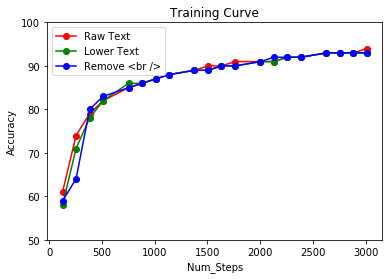

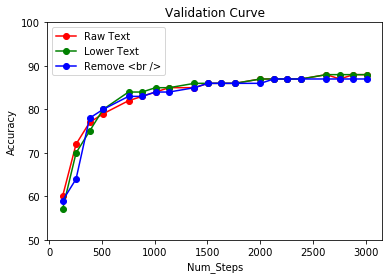

In [162]:
##############
# emb dim
##############
import matplotlib.pyplot as plt

learning_rate = 0.001
vocab_size = 20000 # number of n-grams to use
emb_dim = 50 
num_epochs = 5 
batch_size = 32

step_list = []
val_list = []
train_list = []



#for ngram_n in ngram_n_list:
for scheme_i in range(3):
    if i == 0:
        def preprocess_text(text):
            """
            Function that cleans the string
            """
            return text
    elif i == 1:
        def preprocess_text(text):
            """
            Function that cleans the string
            """
            text = text.lower()
            return text
    else:
        
        def preprocess_text(text):
            """
            Function that cleans the string
            """
            text = text.lower().replace("<br />", "")
            return text
        
    train_set = construct_dataset(train_dir, TRAIN_SIZE)
    validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
    test_set = construct_dataset(test_dir, TEST_SIZE)

    train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
    validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
    test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

    # consturct datasets
    imdb_train = IMDBDataset(train_data)
    imdb_validation = IMDBDataset(validation_data)
    imdb_test = IMDBDataset(test_data)    

    # construct data loader
    train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                               batch_size=batch_size, 
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)



    model = FastText(vocab_size, emb_dim)
    # Loss and Optimizer
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    validation_acc_history = []
    train_acc_history = []
    step_history = []
    
    stop_training = False
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*4) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                validation_acc_history.append(val_acc)
                train_acc_history.append(train_acc)
                step_history.append(625*epoch + i)
                # check if we need to earily stop the model
                stop_training = earily_stop(validation_acc_history)
                if stop_training:
                    print("earily stop triggered")
                    break
        # because of the the nested loop
        if stop_training:
            break
    val_list.append(validation_acc_history)
    train_list.append(train_acc_history)
    step_list.append(step_history)
plt.title("Training Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0], train_list[0], 'o-', color="r",
                 label="Raw Text")
plt.plot(step_list[1], train_list[1], 'o-', color="g",
                 label="Lower Text")
plt.plot(step_list[2], train_list[2], 'o-', color="b",
                 label="Remove <br />")


plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0],val_list[0], 'o-', color="r",
                 label="Raw Text")
plt.plot(step_list[1],val_list[1], 'o-', color="g",
                 label="Lower Text")
plt.plot(step_list[2],val_list[2], 'o-', color="b",
                 label="Remove <br />")

plt.legend(loc="best")

plt.show()

In [163]:
def extract_ngram_from_text(text, n, remove_stopwords=False):
    """
    Function that retrieves all n-grams from the input string
    @param text: raw string
    @param n: integer that tells the model to retrieve all k-gram where k<=n
    @return ngram_counter: a counter that maps n-gram to its frequency
    @return tokens: a list of parsed ngrams
    """
    # tokenize words - for simplicity just split by space
    tokens = text.split(" ")
#     if remove_stopwords:
#         tokens = [token for token in tokens if token not in stop_words.ENGLISH_STOP_WORDS]
    # extract n grams
    # TODO: replace with your code
    ngram_counter = Counter()
    ngram_counter.update(tokens)
    for j in np.arange(n):
        if j > 0:
            for i in np.arange(len(tokens)-j):
                ngram_counter[" ".join(tokens[i:i+j+1])]+=1
    all_ngrams = ngram_counter.keys()
    return ngram_counter, all_ngrams

train_set = construct_dataset(train_dir, TRAIN_SIZE)
validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
test_set = construct_dataset(test_dir, TEST_SIZE)

train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    

# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)



model = FastText(vocab_size, emb_dim)
# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

validation_acc_history = []
train_acc_history = []
step_history = []

stop_training = False
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            train_acc = test_model(train_loader, model)
            val_acc = test_model(validation_loader, model)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                    train_acc, val_acc))
            validation_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
            step_history.append(625*epoch + i)
            # check if we need to earily stop the model
            stop_training = earily_stop(validation_acc_history)
            if stop_training:
                print("earily stop triggered")
                break
    # because of the the nested loop
    if stop_training:
        break
val_list.append(validation_acc_history)
train_list.append(train_acc_history)
step_list.append(step_history)

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.6830908060073853, Train Acc: 64, Validation Acc:64
Epoch: [1/5], Step: [256/625], Loss: 0.6670528054237366, Train Acc: 72, Validation Acc:72
Epoch: [1/5], Step: [384/625], Loss: 0.6098200082778931, Train Acc: 79, Validation Acc:78
Epoch: [1/5], Step: [512/625], Loss: 0.6026390194892883, Train Acc: 82, Validation Acc:81
Epoch: [2/5], Step: [128/625], Loss: 0.44010981917381287, Train Acc: 85, Validation Acc:82
Epoch: [2/5], Step: [256/625], Loss: 0.36946961283683777, Train Acc: 86, Validation Acc:83
Epoch: [2/5], Step: [384/625], Loss: 0.3152673542499542, Train Acc: 87, Validation Acc:84
Epoch: [2/5], Step: [512/625], Loss: 0.3346921503543854, Train Acc: 88, Validation Acc:85
Epoch: [3/5], Step: [128/625], Loss: 0.3659411370754242, Train Acc: 89, Validation Acc:86
Epoch: [3/5], Step: [256/625], Loss: 0.2764418125152588, Train Acc: 89, Validation Acc:86
Epoch: [3/5], Step: [384/625], Loss: 0.22220849990844727, Train Acc: 90, Validation Acc:86
Epoch: 

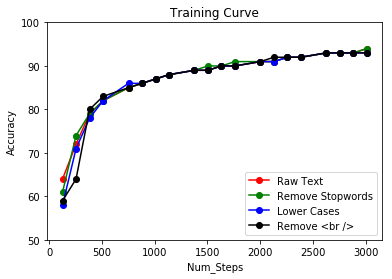

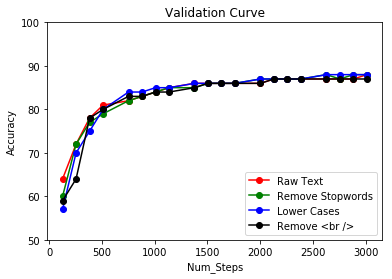

In [164]:
plt.title("Training Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[-1], train_list[-1], 'o-', color="r",
                 label="Raw Text")
plt.plot(step_list[0], train_list[0], 'o-', color="g",
                 label="Remove Stopwords")
plt.plot(step_list[1], train_list[1], 'o-', color="b",
                 label="Lower Cases")
plt.plot(step_list[2], train_list[2], 'o-', color="k",
                 label="Remove <br />")



plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[-1],val_list[-1], 'o-', color="r",
                 label="Raw Text")
plt.plot(step_list[0],val_list[0], 'o-', color="g",
                 label="Remove Stopwords")
plt.plot(step_list[1],val_list[1], 'o-', color="b",
                 label="Lower Cases")
plt.plot(step_list[2],val_list[2], 'o-', color="k",
                 label="Remove <br />")

plt.legend(loc="best")

plt.show()

### Model Hyperparameters

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.689536988735199, Train Acc: 58, Validation Acc:56
Epoch: [1/5], Step: [256/625], Loss: 0.6701663732528687, Train Acc: 66, Validation Acc:64
Epoch: [1/5], Step: [384/625], Loss: 0.6373070478439331, Train Acc: 69, Validation Acc:67
Epoch: [1/5], Step: [512/625], Loss: 0.6039835810661316, Train Acc: 72, Validation Acc:71
Epoch: [2/5], Step: [128/625], Loss: 0.5749898552894592, Train Acc: 75, Validation Acc:74
Epoch: [2/5], Step: [256/625], Loss: 0.4627753794193268, Train Acc: 76, Validation Acc:75
Epoch: [2/5], Step: [384/625], Loss: 0.5619975328445435, Train Acc: 76, Validation Acc:75
Epoch: [2/5], Step: [512/625], Loss: 0.60403972864151, Train Acc: 77, Validation Acc:76
Epoch: [3/5], Step: [128/625], Loss: 0.47142642736434937, Train Acc: 78, Validation Acc:76
Epoch: [3/5], Step: [256/625], Loss: 0.34185293316841125, Train Acc: 78, Validation Acc:76
Epoch: [3/5], Step: [384/625], Loss: 0.46430379152297974, Train Acc: 78, Validation Acc:77
Epoch: [3/

Epoch: [3/5], Step: [512/625], Loss: 0.22480718791484833, Train Acc: 91, Validation Acc:86
Epoch: [4/5], Step: [128/625], Loss: 0.14980348944664001, Train Acc: 92, Validation Acc:87
Epoch: [4/5], Step: [256/625], Loss: 0.16030265390872955, Train Acc: 93, Validation Acc:87
Epoch: [4/5], Step: [384/625], Loss: 0.24398194253444672, Train Acc: 93, Validation Acc:87
Epoch: [4/5], Step: [512/625], Loss: 0.20479905605316162, Train Acc: 93, Validation Acc:87
Epoch: [5/5], Step: [128/625], Loss: 0.09629084914922714, Train Acc: 94, Validation Acc:88
Epoch: [5/5], Step: [256/625], Loss: 0.19035404920578003, Train Acc: 94, Validation Acc:88
Epoch: [5/5], Step: [384/625], Loss: 0.31278690695762634, Train Acc: 94, Validation Acc:88
Epoch: [5/5], Step: [512/625], Loss: 0.2302480936050415, Train Acc: 95, Validation Acc:88


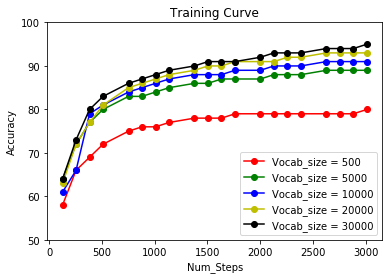

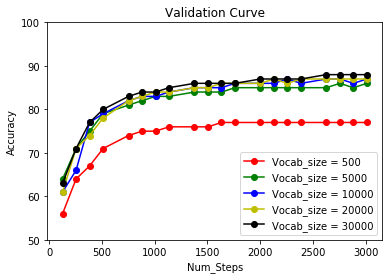

In [142]:
##############
# Vocab Size
##############
import matplotlib.pyplot as plt

learning_rate = 0.001
vocab_size = 20000 # number of n-grams to use
emb_dim = 50 
num_epochs = 5 
batch_size = 32

ngram_n_list = [1, 2, 3, 4]
emb_dim_list = [10, 20, 50, 100]
vocab_size_list = [500, 5000, 10000, 20000, 30000]

step_list = []
val_list = []
train_list = []

def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", "")
    return text

#for ngram_n in ngram_n_list:
#    for emb_dim in emb_dim_list:
for vocab_size in vocab_size_list:
    # Load Dataset - should take less than 1 min
    train_set = construct_dataset(train_dir, TRAIN_SIZE)
    validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
    test_set = construct_dataset(test_dir, TEST_SIZE)

    train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
    validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
    test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

    # consturct datasets
    imdb_train = IMDBDataset(train_data)
    imdb_validation = IMDBDataset(validation_data)
    imdb_test = IMDBDataset(test_data)    

    # construct data loader
    train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                               batch_size=batch_size, 
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)



    model = FastText(vocab_size, emb_dim)
    # Loss and Optimizer
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    validation_acc_history = []
    train_acc_history = []
    step_history = []
    
    stop_training = False
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*4) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                validation_acc_history.append(val_acc)
                train_acc_history.append(train_acc)
                step_history.append(625*epoch + i)
                # check if we need to earily stop the model
                stop_training = earily_stop(validation_acc_history)
                if stop_training:
                    print("earily stop triggered")
                    break
        # because of the the nested loop
        if stop_training:
            break
    val_list.append(validation_acc_history)
    train_list.append(train_acc_history)
    step_list.append(step_history)
plt.title("Training Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0], train_list[0], 'o-', color="r",
                 label="Vocab_size = 500")
plt.plot(step_list[1], train_list[1], 'o-', color="g",
                 label="Vocab_size = 5000")
plt.plot(step_list[2], train_list[2], 'o-', color="b",
                 label="Vocab_size = 10000")
plt.plot(step_list[3], train_list[3], 'o-', color="y",
                 label="Vocab_size = 20000")
plt.plot(step_list[4], train_list[4], 'o-', color="k",
                 label="Vocab_size = 30000")

plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0],val_list[0], 'o-', color="r",
                 label="Vocab_size = 500")
plt.plot(step_list[1],val_list[1], 'o-', color="g",
                 label="Vocab_size = 5000")
plt.plot(step_list[2],val_list[2], 'o-', color="b",
                 label="Vocab_size = 10000")
plt.plot(step_list[3],val_list[3], 'o-', color="y",
                 label="Vocab_size = 20000")
plt.plot(step_list[4],val_list[4], 'o-', color="k",
                 label="Vocab_size = 30000")

plt.legend(loc="best")

plt.show()


### Optimization Hyperparameters

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.6950799226760864, Train Acc: 61, Validation Acc:60
Epoch: [1/5], Step: [256/625], Loss: 0.6682965755462646, Train Acc: 71, Validation Acc:70
Epoch: [1/5], Step: [384/625], Loss: 0.6201693415641785, Train Acc: 77, Validation Acc:75
Epoch: [1/5], Step: [512/625], Loss: 0.5865890979766846, Train Acc: 79, Validation Acc:77
Epoch: [2/5], Step: [128/625], Loss: 0.49403607845306396, Train Acc: 84, Validation Acc:81
Epoch: [2/5], Step: [256/625], Loss: 0.442990243434906, Train Acc: 85, Validation Acc:82
Epoch: [2/5], Step: [384/625], Loss: 0.48212435841560364, Train Acc: 86, Validation Acc:83
Epoch: [2/5], Step: [512/625], Loss: 0.3810904324054718, Train Acc: 87, Validation Acc:83
Epoch: [3/5], Step: [128/625], Loss: 0.34626275300979614, Train Acc: 88, Validation Acc:84
Epoch: [3/5], Step: [256/625], Loss: 0.38173630833625793, Train Acc: 89, Validation Acc:85
Epoch: [3/5], Step: [384/625], Loss: 0.2269294410943985, Train Acc: 89, Validation Acc:85
Epoch: 

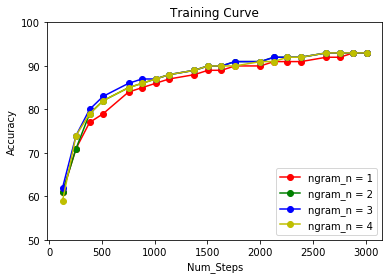

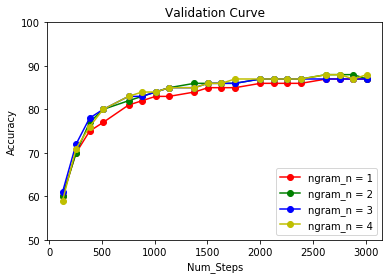

In [143]:
##############
# ngram n
##############
import matplotlib.pyplot as plt

learning_rate = 0.001
vocab_size = 20000 # number of n-grams to use
emb_dim = 50 
num_epochs = 5 
batch_size = 32

ngram_n_list = [1, 2, 3, 4]
emb_dim_list = [10, 20, 50, 100]
vocab_size_list = [500, 5000, 10000, 20000, 30000]

step_list = []
val_list = []
train_list = []

def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", "")
    return text

for ngram_n in ngram_n_list:
#    for emb_dim in emb_dim_list:
#for vocab_size in vocab_size_list:
    # Load Dataset - should take less than 1 min
    train_set = construct_dataset(train_dir, TRAIN_SIZE)
    validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
    test_set = construct_dataset(test_dir, TEST_SIZE)

    train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
    validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
    test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

    # consturct datasets
    imdb_train = IMDBDataset(train_data)
    imdb_validation = IMDBDataset(validation_data)
    imdb_test = IMDBDataset(test_data)    

    # construct data loader
    train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                               batch_size=batch_size, 
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)



    model = FastText(vocab_size, emb_dim)
    # Loss and Optimizer
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    validation_acc_history = []
    train_acc_history = []
    step_history = []
    
    stop_training = False
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*4) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                validation_acc_history.append(val_acc)
                train_acc_history.append(train_acc)
                step_history.append(625*epoch + i)
                # check if we need to earily stop the model
                stop_training = earily_stop(validation_acc_history)
                if stop_training:
                    print("earily stop triggered")
                    break
        # because of the the nested loop
        if stop_training:
            break
    val_list.append(validation_acc_history)
    train_list.append(train_acc_history)
    step_list.append(step_history)
plt.title("Training Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0], train_list[0], 'o-', color="r",
                 label="ngram_n = 1")
plt.plot(step_list[1], train_list[1], 'o-', color="g",
                 label="ngram_n = 2")
plt.plot(step_list[2], train_list[2], 'o-', color="b",
                 label="ngram_n = 3")
plt.plot(step_list[3], train_list[3], 'o-', color="y",
                 label="ngram_n = 4")

plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0],val_list[0], 'o-', color="r",
                 label="ngram_n = 1")
plt.plot(step_list[1],val_list[1], 'o-', color="g",
                 label="ngram_n = 2")
plt.plot(step_list[2],val_list[2], 'o-', color="b",
                 label="ngram_n = 3")
plt.plot(step_list[3],val_list[3], 'o-', color="y",
                 label="ngram_n = 4")

plt.legend(loc="best")

plt.show()


In [187]:
##############
# emb dim
##############
import matplotlib.pyplot as plt

learning_rate = 0.001
vocab_size = 20000 # number of n-grams to use
emb_dim = 50 
num_epochs = 5 
batch_size = 32

ngram_n_list = [1, 2, 3, 4]
emb_dim_list = [10, 20, 50, 100, 200, 1000, 5000]
vocab_size_list = [500, 5000, 10000, 20000, 30000]

step_list = []
val_list = []
train_list = []

def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", "")
    return text

#for ngram_n in ngram_n_list:
for emb_dim in emb_dim_list:
#for vocab_size in vocab_size_list:
    # Load Dataset - should take less than 1 min
    train_set = construct_dataset(train_dir, TRAIN_SIZE)
    validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
    test_set = construct_dataset(test_dir, TEST_SIZE)

    train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
    validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
    test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

    # consturct datasets
    imdb_train = IMDBDataset(train_data)
    imdb_validation = IMDBDataset(validation_data)
    imdb_test = IMDBDataset(test_data)    

    # construct data loader
    train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                               batch_size=batch_size, 
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)



    model = FastText(vocab_size, emb_dim)
    # Loss and Optimizer
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    validation_acc_history = []
    train_acc_history = []
    step_history = []
    
    stop_training = False
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*4) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                validation_acc_history.append(val_acc)
                train_acc_history.append(train_acc)
                step_history.append(625*epoch + i)
                # check if we need to earily stop the model
                stop_training = earily_stop(validation_acc_history)
                if stop_training:
                    print("earily stop triggered")
                    break
        # because of the the nested loop
        if stop_training:
            break
    val_list.append(validation_acc_history)
    train_list.append(train_acc_history)
    step_list.append(step_history)
plt.title("Training Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0], train_list[0], 'o-', color="r",
                 label="emb_dim = 10")
plt.plot(step_list[1], train_list[1], 'o-', color="g",
                 label="emb_dim = 20")
plt.plot(step_list[2], train_list[2], 'o-', color="b",
                 label="emb_dim = 50")
plt.plot(step_list[3], train_list[3], 'o-', color="y",
                 label="emb_dim = 100")
plt.plot(step_list[4], train_list[4], 'o-', color="k",
                 label="emb_dim = 200")

plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0],val_list[0], 'o-', color="r",
                 label="emb_dim = 10")
plt.plot(step_list[1],val_list[1], 'o-', color="g",
                 label="emb_dim = 20")
plt.plot(step_list[2],val_list[2], 'o-', color="b",
                 label="emb_dim = 50")
plt.plot(step_list[3],val_list[3], 'o-', color="y",
                 label="emb_dim = 100")
plt.plot(step_list[4],val_list[4], 'o-', color="k",
                 label="emb_dim = 200")

plt.legend(loc="best")

plt.show()


/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.6872093081474304, Train Acc: 57, Validation Acc:56
Epoch: [1/5], Step: [256/625], Loss: 0.6817591190338135, Train Acc: 65, Validation Acc:63
Epoch: [1/5], Step: [384/625], Loss: 0.6707042455673218, Train Acc: 70, Validation Acc:68
Epoch: [1/5], Step: [512/625], Loss: 0.6622225046157837, Train Acc: 75, Validation Acc:73
Epoch: [2/5], Step: [128/625], Loss: 0.6065929532051086, Train Acc: 80, Validation Acc:77
Epoch: [2/5], Step: [256/625], Loss: 0.5637372136116028, Train Acc: 82, Validation Acc:79
Epoch: [2/5], Step: [384/625], Loss: 0.565377950668335, Train Acc: 83, Validation Acc:80
Epoch: [2/5], Step: [512/625], Loss: 0.473228394985199, Train Acc: 84, Validation Acc:81
Epoch: [3/5], Step: [128/625], Loss: 0.4948295056819916, Train Acc: 85, Validation Acc:82
Epoch: [3/5], Step: [256/625], Loss: 0.43898728489875793, Train Acc: 85, Validation Acc:82
Epoch: [3/5], Step: [384/625], Loss: 0.488338828086853, Train Acc: 86, Validation Acc:83
Epoch: [3/5]

Epoch: [3/5], Step: [512/625], Loss: 0.1603628247976303, Train Acc: 93, Validation Acc:88
Epoch: [4/5], Step: [128/625], Loss: 0.14251475036144257, Train Acc: 94, Validation Acc:88
Epoch: [4/5], Step: [256/625], Loss: 0.14899848401546478, Train Acc: 95, Validation Acc:88
Epoch: [4/5], Step: [384/625], Loss: 0.27480778098106384, Train Acc: 95, Validation Acc:88
Epoch: [4/5], Step: [512/625], Loss: 0.11129093915224075, Train Acc: 95, Validation Acc:88
Epoch: [5/5], Step: [128/625], Loss: 0.15630121529102325, Train Acc: 96, Validation Acc:88
Epoch: [5/5], Step: [256/625], Loss: 0.13682478666305542, Train Acc: 96, Validation Acc:88
Epoch: [5/5], Step: [384/625], Loss: 0.10327945649623871, Train Acc: 96, Validation Acc:88
Epoch: [5/5], Step: [512/625], Loss: 0.09168113768100739, Train Acc: 97, Validation Acc:88
Epoch: [1/5], Step: [128/625], Loss: 0.6565650701522827, Train Acc: 81, Validation Acc:79
Epoch: [1/5], Step: [256/625], Loss: 0.5451880693435669, Train Acc: 84, Validation Acc:82
Ep

KeyboardInterrupt: 

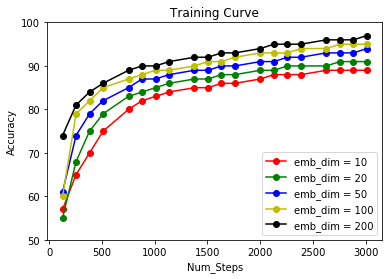

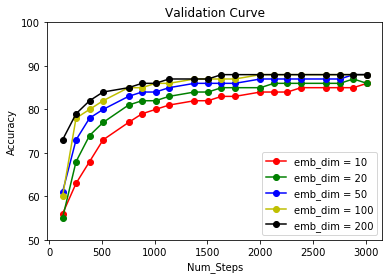

In [188]:
plt.title("Training Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0], train_list[0], 'o-', color="r",
                 label="emb_dim = 10")
plt.plot(step_list[1], train_list[1], 'o-', color="g",
                 label="emb_dim = 20")
plt.plot(step_list[2], train_list[2], 'o-', color="b",
                 label="emb_dim = 50")
plt.plot(step_list[3], train_list[3], 'o-', color="y",
                 label="emb_dim = 100")
plt.plot(step_list[4], train_list[4], 'o-', color="k",
                 label="emb_dim = 200")

plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0],val_list[0], 'o-', color="r",
                 label="emb_dim = 10")
plt.plot(step_list[1],val_list[1], 'o-', color="g",
                 label="emb_dim = 20")
plt.plot(step_list[2],val_list[2], 'o-', color="b",
                 label="emb_dim = 50")
plt.plot(step_list[3],val_list[3], 'o-', color="y",
                 label="emb_dim = 100")
plt.plot(step_list[4],val_list[4], 'o-', color="k",
                 label="emb_dim = 200")

plt.legend(loc="best")

plt.show()

### Optimization Hyperparameters

In [145]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [147]:
##############
# learning rate Adam
##############
import matplotlib.pyplot as plt

learning_rate = 0.001
vocab_size = 20000 # number of n-grams to use
emb_dim = 50 
num_epochs = 5 
batch_size = 32

learning_rate_list = [0.1, 0.01, 0.001, 0.0001]
step_list = []
val_list = []
train_list = []

def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", "")
    return text

#for ngram_n in ngram_n_list:
for learning_rate in learning_rate_list:
#for vocab_size in vocab_size_list:
    # Load Dataset - should take less than 1 min
    train_set = construct_dataset(train_dir, TRAIN_SIZE)
    validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
    test_set = construct_dataset(test_dir, TEST_SIZE)

    train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
    validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
    test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

    # consturct datasets
    imdb_train = IMDBDataset(train_data)
    imdb_validation = IMDBDataset(validation_data)
    imdb_test = IMDBDataset(test_data)    

    # construct data loader
    train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                               batch_size=batch_size, 
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)



    model = FastText(vocab_size, emb_dim)
    # Loss and Optimizer
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    validation_acc_history = []
    train_acc_history = []
    step_history = []
    
    stop_training = False
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*4) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                validation_acc_history.append(val_acc)
                train_acc_history.append(train_acc)
                step_history.append(625*epoch + i)
                # check if we need to earily stop the model
                stop_training = earily_stop(validation_acc_history)
                if stop_training:
                    print("earily stop triggered")
                    break
        # because of the the nested loop
        if stop_training:
            break
    val_list.append(validation_acc_history)
    train_list.append(train_acc_history)
    step_list.append(step_history)

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.37239861488342285, Train Acc: 85, Validation Acc:82
Epoch: [1/5], Step: [256/625], Loss: 0.30335018038749695, Train Acc: 90, Validation Acc:85
Epoch: [1/5], Step: [384/625], Loss: 0.298858642578125, Train Acc: 92, Validation Acc:86
Epoch: [1/5], Step: [512/625], Loss: 0.33657515048980713, Train Acc: 94, Validation Acc:86
Epoch: [2/5], Step: [128/625], Loss: 0.260709673166275, Train Acc: 94, Validation Acc:85
Epoch: [2/5], Step: [256/625], Loss: 0.12707597017288208, Train Acc: 95, Validation Acc:85
Epoch: [2/5], Step: [384/625], Loss: 0.3639947175979614, Train Acc: 96, Validation Acc:86
Epoch: [2/5], Step: [512/625], Loss: 0.10813681036233902, Train Acc: 95, Validation Acc:84
Epoch: [3/5], Step: [128/625], Loss: 0.03150598704814911, Train Acc: 97, Validation Acc:86
Epoch: [3/5], Step: [256/625], Loss: 0.016185715794563293, Train Acc: 97, Validation Acc:85
Epoch: [3/5], Step: [384/625], Loss: 0.06350645422935486, Train Acc: 97, Validation Acc:85
Epo

RuntimeError: value cannot be converted to type int64_t without overflow: inf

In [158]:
learning_rate = 0.1

# train_set = construct_dataset(train_dir, TRAIN_SIZE)
# validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
# test_set = construct_dataset(test_dir, TEST_SIZE)

# train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
# validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
# test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

# # consturct datasets
# imdb_train = IMDBDataset(train_data)
# imdb_validation = IMDBDataset(validation_data)
# imdb_test = IMDBDataset(test_data)    

# # construct data loader
# train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
#                                            batch_size=batch_size,
#                                            collate_fn=imdb_collate_func,
#                                            shuffle=True)
# validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
#                                            batch_size=batch_size, 
#                                            collate_fn=imdb_collate_func,
#                                            shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
#                                            batch_size=batch_size,
#                                            collate_fn=imdb_collate_func,
#                                            shuffle=False)



model = FastText(vocab_size, emb_dim)
# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = ReduceLROnPlateau(optimizer, 'max', patience = 1)
validation_acc_history = []
train_acc_history = []
step_history = []

stop_training = False
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            train_acc = test_model(train_loader, model)
            val_acc = test_model(validation_loader, model)
            scheduler.step(val_acc.float())
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                    train_acc, val_acc))
            validation_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
            step_history.append(625*epoch + i)
            # check if we need to earily stop the model
            stop_training = earily_stop(validation_acc_history)
            if stop_training:
                print("earily stop triggered")
                break
    # because of the the nested loop
    if stop_training:
        break
val_list.append(validation_acc_history)
train_list.append(train_acc_history)
step_list.append(step_history)


/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.3145751655101776, Train Acc: 88, Validation Acc:84
Epoch: [1/5], Step: [256/625], Loss: 0.23613272607326508, Train Acc: 91, Validation Acc:86
Epoch: [1/5], Step: [384/625], Loss: 0.5995160937309265, Train Acc: 93, Validation Acc:86
Epoch: [1/5], Step: [512/625], Loss: 0.2878165543079376, Train Acc: 93, Validation Acc:87
Epoch: [2/5], Step: [128/625], Loss: 0.17311814427375793, Train Acc: 96, Validation Acc:87
Epoch: [2/5], Step: [256/625], Loss: 0.12510086596012115, Train Acc: 95, Validation Acc:85
Epoch: [2/5], Step: [384/625], Loss: 0.08140745013952255, Train Acc: 97, Validation Acc:86
Epoch: [2/5], Step: [512/625], Loss: 0.33395150303840637, Train Acc: 97, Validation Acc:86
Epoch: [3/5], Step: [128/625], Loss: 0.06065624952316284, Train Acc: 97, Validation Acc:87
Epoch: [3/5], Step: [256/625], Loss: 0.04610515758395195, Train Acc: 97, Validation Acc:86
Epoch: [3/5], Step: [384/625], Loss: 0.031045107170939445, Train Acc: 97, Validation Acc:86
E

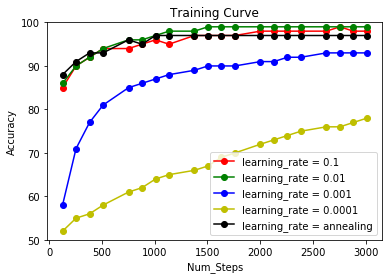

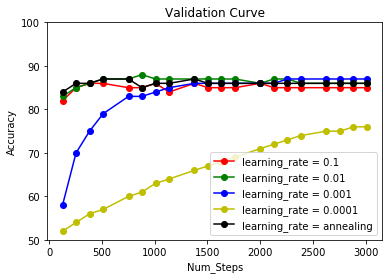

In [160]:
plt.title("Training Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0], train_list[0], 'o-', color="r",
                 label="learning_rate = 0.1")
plt.plot(step_list[1], train_list[1], 'o-', color="g",
                 label="learning_rate = 0.01")
plt.plot(step_list[2], train_list[2], 'o-', color="b",
                 label="learning_rate = 0.001")
plt.plot(step_list[3], train_list[3], 'o-', color="y",
                 label="learning_rate = 0.0001")
plt.plot(step_list[-1],train_list[-1], 'o-', color="k",
                 label="learning_rate = annealing")

plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0],val_list[0], 'o-', color="r",
                 label="learning_rate = 0.1")
plt.plot(step_list[1],val_list[1], 'o-', color="g",
                 label="learning_rate = 0.01")
plt.plot(step_list[2],val_list[2], 'o-', color="b",
                 label="learning_rate = 0.001")
plt.plot(step_list[3],val_list[3], 'o-', color="y",
                 label="learning_rate = 0.0001")
plt.plot(step_list[-1],val_list[-1], 'o-', color="k",
                 label="learning_rate = annealing")

plt.legend(loc="best")

plt.show()


In [166]:
train_set = construct_dataset(train_dir, TRAIN_SIZE)
validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
test_set = construct_dataset(test_dir, TEST_SIZE)

train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    

# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)



/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.7421375513076782, Train Acc: 52, Validation Acc:52
Epoch: [1/5], Step: [256/625], Loss: 0.665962815284729, Train Acc: 52, Validation Acc:52
Epoch: [1/5], Step: [384/625], Loss: 0.6746814846992493, Train Acc: 57, Validation Acc:57
Epoch: [1/5], Step: [512/625], Loss: 0.6844000220298767, Train Acc: 58, Validation Acc:56
Epoch: [2/5], Step: [128/625], Loss: 0.6604800820350647, Train Acc: 59, Validation Acc:58
Epoch: [2/5], Step: [256/625], Loss: 0.7049452662467957, Train Acc: 61, Validation Acc:60
Epoch: [2/5], Step: [384/625], Loss: 0.6862415075302124, Train Acc: 62, Validation Acc:60
Epoch: [2/5], Step: [512/625], Loss: 0.6377253532409668, Train Acc: 61, Validation Acc:59
Epoch: [3/5], Step: [128/625], Loss: 0.682553231716156, Train Acc: 64, Validation Acc:61
Epoch: [3/5], Step: [256/625], Loss: 0.6829376816749573, Train Acc: 64, Validation Acc:61
Epoch: [3/5], Step: [384/625], Loss: 0.6211042404174805, Train Acc: 66, Validation Acc:64
Epoch: [3/5]

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [128/625], Loss: 0.6408392190933228, Train Acc: 65, Validation Acc:64
Epoch: [1/5], Step: [256/625], Loss: 1.130346417427063, Train Acc: 62, Validation Acc:61
Epoch: [1/5], Step: [384/625], Loss: 0.9985924363136292, Train Acc: 64, Validation Acc:63
Epoch: [1/5], Step: [512/625], Loss: 0.6724685430526733, Train Acc: 75, Validation Acc:72
Epoch: [2/5], Step: [128/625], Loss: 0.3267107903957367, Train Acc: 85, Validation Acc:82
Epoch: [2/5], Step: [256/625], Loss: 0.4647173583507538, Train Acc: 86, Validation Acc:83
Epoch: [2/5], Step: [384/625], Loss: 0.6651812195777893, Train Acc: 82, Validation Acc:79
Epoch: [2/5], Step: [512/625], Loss: 0.3550136089324951, Train Acc: 84, Validation Acc:80
Epoch: [3/5], Step: [128/625], Loss: 0.2369283139705658, Train Acc: 90, Validation Acc:86
Epoch: [3/5], Step: [256/625], Loss: 0.27326926589012146, Train Acc: 89, Validation Acc:85
Epoch: [3/5], Step: [384/625], Loss: 0.0666036531329155, Train Acc: 88, Validation Acc:84
earily sto

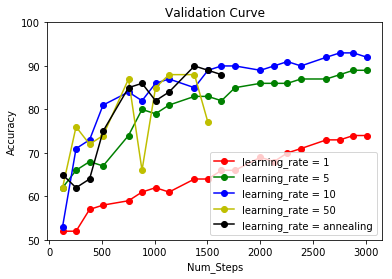

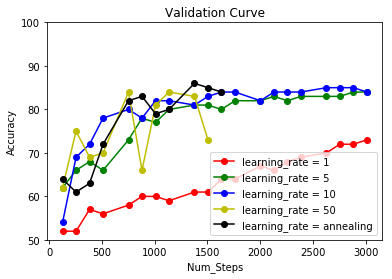

In [185]:
##############
# learning rate SGD
##############
import matplotlib.pyplot as plt

learning_rate = 0.001
vocab_size = 20000 # number of n-grams to use
emb_dim = 50 
num_epochs = 5 
batch_size = 32

learning_rate_list = [1, 5, 10, 20]
step_list = []
val_list = []
train_list = []

for learning_rate in learning_rate_list:
    
    model = FastText(vocab_size, emb_dim)
    # Loss and Optimizer
    criterion = nn.BCELoss()  
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
    validation_acc_history = []
    train_acc_history = []
    step_history = []
    
    stop_training = False
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*4) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                validation_acc_history.append(val_acc)
                train_acc_history.append(train_acc)
                step_history.append(625*epoch + i)
                # check if we need to earily stop the model
                stop_training = earily_stop(validation_acc_history)
                if stop_training:
                    print("earily stop triggered")
                    break
        # because of the the nested loop
        if stop_training:
            break
    val_list.append(validation_acc_history)
    train_list.append(train_acc_history)
    step_list.append(step_history)

learning_rate = 20
    

model = FastText(vocab_size, emb_dim)
# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
scheduler = ReduceLROnPlateau(optimizer, 'max')
validation_acc_history = []
train_acc_history = []
step_history = []

stop_training = False
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            train_acc = test_model(train_loader, model)
            val_acc = test_model(validation_loader, model)
            scheduler.step(val_acc.float())
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                    train_acc, val_acc))
            validation_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
            step_history.append(625*epoch + i)
            # check if we need to earily stop the model
            stop_training = earily_stop(validation_acc_history)
            if stop_training:
                print("earily stop triggered")
                break
    # because of the the nested loop
    if stop_training:
        break
val_list.append(validation_acc_history)
train_list.append(train_acc_history)
step_list.append(step_history)



plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0], train_list[0], 'o-', color="r",
                 label="learning_rate = 1")
plt.plot(step_list[1], train_list[1], 'o-', color="g",
                 label="learning_rate = 5")
plt.plot(step_list[2], train_list[2], 'o-', color="b",
                 label="learning_rate = 10")
plt.plot(step_list[3], train_list[3], 'o-', color="y",
                 label="learning_rate = 50")
plt.plot(step_list[4], train_list[4], 'o-', color="k",
                 label="learning_rate = annealing")

plt.legend(loc="best")

plt.show()

        
plt.title("Validation Curve")
plt.xlabel("Num_Steps")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

plt.plot(step_list[0],val_list[0], 'o-', color="r",
                 label="learning_rate = 1")
plt.plot(step_list[1],val_list[1], 'o-', color="g",
                 label="learning_rate = 5")
plt.plot(step_list[2],val_list[2], 'o-', color="b",
                 label="learning_rate = 10")
plt.plot(step_list[3],val_list[3], 'o-', color="y",
                 label="learning_rate = 50")
plt.plot(step_list[4],val_list[4], 'o-', color="k",
                 label="learning_rate = annealing")

plt.legend(loc="best")

plt.show()


## Error Analysis

In [ ]:
loader = val_loader


model.eval()
false_positive = []
false_negative = []
true_positive = []
true_negative = []
j = 0
for data, lengths, labels in loader:
    data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
    outputs = model(data_batch, length_batch)
    predicted = (outputs.data > 0.5).long().view(-1)
    for i in np.arange(predicted.size(0)):
        if predicted[i] != labels[i]:
            if predicted[i] == 1:
                false_positive.append(j*batch_size+i)
            else:
                false_negative.append(j*batch_size+i)
        elif predicted[i] == labels[i]:
            if predicted[i] ==1:
                true_positive.append(j*batch_size+i)
            else:
                true_negative.append(j*batch_size+i)
    j += 1
model.train()

print(loader.dataset.data_list[false_positive[5]].raw_text)